In [87]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.exposure import equalize_hist
from scipy.interpolate import interp1d
from scipy.signal import medfilt
from scipy.ndimage import median_filter
from PIL import Image
from datetime import datetime

In [2]:
# Import 2-theta map from CeO2 calibration
tmap = imread('Standard/maps/day2_plate2_CeO2_OB5-000000_2thetamap.tif')
# Import polarization scaling map
pmap = imread('Standard/maps/day2_plate2_CeO2_OB5-000000_polscalemap.tif')

In [9]:
# Import air blanks
a1 = imread('cap_air_ps7-000000.tif')
a2 = imread('cap_air_ps7-000000-00001.tif')
# Import glass blanks
g1 = imread('glass_bkgd_ps2_c8-000000.tif')
g2 = imread('glass_bkgd_ps2_c8-000001.tif')

# Apply polarization correction
a1 = np.divide(a1, pmap)
a2 = np.divide(a2, pmap)
g1 = np.divide(g1, pmap)
g2 = np.divide(g2, pmap)

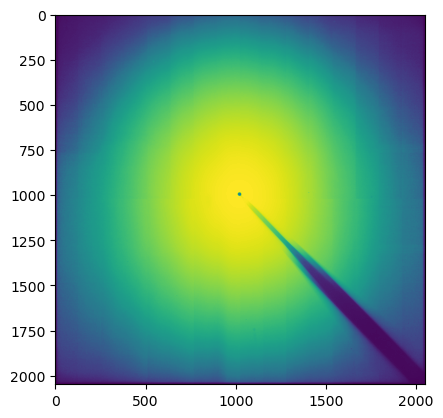

In [10]:
# Plot histogram equalized pattern to make sure polarization correction is applied
# Image will have a vertical football shape if polarization correction is not applied correctly
# Image will be circular if polarization correction is applied correctly
plt.imshow(equalize_hist(a1))

In [62]:
def bin_map(tmap, nbins):
    """
    Bin 2-theta map
    Input (2-theta map, total number of bins)
    Return bin, map of bin index
    """
    bins = np.linspace(np.min(tmap), np.max(tmap), num = nbins)
    binned = np.digitize(tmap, bins) -1 # Digitize index starts at 1
    return bins, binned

def unwrap_image(data, datamap, bins = 800):
    """
    Unwraps a 2D diffraction image
    Takes input of diffraction pattern, 2-theta map, and number of bins
        diffraction pattern = data, 2-theta map = datamap, number of bins = bins
    Defaults to 800 bins if no input is provided
    Return bins and unwrapped radial array where rows correspond to each 2-theta bin
    """
    bins, binmap = bin_map(datamap, bins) # Bin input 2-theta map (bins, map of bins)
    values = np.array((binmap.ravel(), data.ravel())) # Values from diffraction pattern (bin, values)
    rind = np.unique(values[0]) # Unique indicies 
    
    avals = [] # Empty array 
    lengths = np.zeros(len(rind)) # Total count of values at each 2-theta
    for i in range (0, len(rind)):
        pos = np.where(values[0] == rind[i])
        vals = np.ndarray.flatten(values[:, pos][1])
        lengths[i] = len(vals)
        avals.append(vals)
   
    radial_array = np.zeros((len(avals), int(np.max(lengths)))) # Output array for unwrapped values
    for i in range (0, len(avals)):
        nan_array = np.empty( int( np.max(lengths) - len(avals[i]) ) ) # Initialize empty array for values not in measurement
        nan_array[:] = np.nan # Set all values in array to NaN
        radial_array[i] = np.concatenate( (avals[i], nan_array) )
    # Return 2-theta bins and unwrapped array
    return bins, radial_array
def interpolate_uwrap(umap, bins, min_val, max_val):
    """
    Interpolate the unwrapped data map and return interpolating function
    Pick range of 2-theta values at high 2-theta to use for extrapolation at high 2-theta
    Pass bootstrapped map, bins from unwrapping function ( unwrap_image() ), min 2theta, and max 2theta
    Extrapolate to twice the input 2-theta value
    """
    median_vals = np.nanmedian(umap, axis = 1) # Take median of bootstrapped array
    f = interp1d(bins, median_vals, kind = 'slinear', fill_value = 'extrapolate') # Interpolate data using order 1 splines
    x_extrap = np.linspace(min_val, max_val, 100) # Get x-values for extrapolation at high 2-theta
    y_extrap = f(x_extrap) # Get y-values for extrapolation from previous interpolation
    f_extrap = interp1d(x_extrap, y_extrap, kind = 'slinear', fill_value = 'extrapolate') # Function for extrapolating high 2-theta using order 1 splines
    # Add median filter to extrapolation section
    f_extrap = interp1d(x_extrap, medfilt(y_extrap, 5), kind = 'slinear', fill_value = 'extrapolate') # Function for extrapolating high 2-theta using order 1 splines
    
    # Calculate new values including extrapolated region
    # Use 5000 points for interpolation for no particular reason
    x_new = np.linspace(bins[0], bins[-1]*2, 5000) # X values
    y_new = [] # Array for y values
    for i in range (0, len(x_new)):
        if x_new[i] <= min_val:
            y_new.append(f(x_new[i])) # Below cutoff use intepolation of data
        if x_new[i] > min_val:
            y_new.append(f_extrap(x_new[i])) # Above cutoff use extrapolation from cutoff range specified
    y_new = np.array(y_new)
    # Calculate interpolating function for new y-values that include extrapolation at high 2-theta
    # Use order 1 splines for interpolation
    f_out = interp1d(x_new,y_new, kind = 'slinear', fill_value = 'extrapolate')
    return f_out

def damaged_pixels(data):
    '''
    Get gain mask of undamaged and damaged pixels (umap, dmap)
    Define damaged pixels as those with responses more than 4 sigma away from the mean
    Define sigma using 1.4826*MAD
    '''
    median = np.nanmedian(data) # Calculate median
    mad = np.nanmedian(np.abs(data-median)) # Calculate MAD
    sigma = 1.4826*mad # Calculate sigma
    dmap = np.copy(data) # Damaged pixels
    dmap[dmap<(median+4*sigma)] = 0
    umap = np.copy(data) # Undamaged pixels
    umap[umap>(median+4*sigma)] = np.nan
    return umap, dmap
def map_correction(gainmap, window_size):
    '''
    Corrects gain map containing damaged pixels
    needs median_filter from scipy.ndimage
    '''
    udmap, damap = damaged_pixels(gainmap) # Get map of undamaged and damaged pixels
    mask = np.copy(udmap) # Mask for damaged pixels
    mask[~np.isnan(mask)] = 1 # Set non nan in mask (undamaged pixels) to one
    mask = np.nan_to_num(mask) # Set nan in mask (damaged pixels) to zero
    filtered = median_filter(gainmap, window_size) # Apply 3x3 median filter to undamaged pixel map
    filtered = filtered*mask # Set damaged pixels to zeros 
    return filtered+damap # Add back in gains for damaged pixels

def estimate_gain(pos, tmap, e_min, e_max, bins = 800):
    '''
    Calculate an estimated gain map from an amorphous scatterer
    Input an image of an amorphous scatterer (pos), 2-theta map (tmap), and a min/max for high Q extrapolation (e_min/e_max)
    '''
    # Unwrap images to generate maps of 2-theta vs number of counts
    bin_pos, unwrapped = unwrap_image(pos, tmap, bins)
    # Get interpolated 1D function corresponding to 1D average of input diffraction patterns
    ifun = interpolate_uwrap(unwrapped, bin_pos, e_min, e_max)
    
    # Estimate signal by mapping interpolated 1D function back to 2-theta map
    signal = ifun(tmap)
    # Estimate gain map by dividing input signal by estimated signal 
    gmap = pos/signal
    # Normalize by dividing by median
    gmap = gmap/np.nanmedian(gmap)
    
    return gmap

In [13]:
# Unwrap images using calculated 2-theta map into a rectangular image
# Rectangular image with rows corresponding to each 2-theta bin
tx1, ty1 = unwrap_image(a1, tmap, bins = 800)
tx2, ty2 = unwrap_image(a2, tmap, bins = 800)
tx3, ty3 = unwrap_image(g1, tmap, bins = 800)
tx4, ty4 = unwrap_image(g2, tmap, bins = 800)
# Calculate median 1D pattern from unwrapped images
y1 = np.nanmedian(ty1, axis = 1)
y2 = np.nanmedian(ty2, axis = 1)
y3 = np.nanmedian(ty3, axis = 1)
y4 = np.nanmedian(ty4, axis = 1)

Text(0, 0.5, 'Counts')

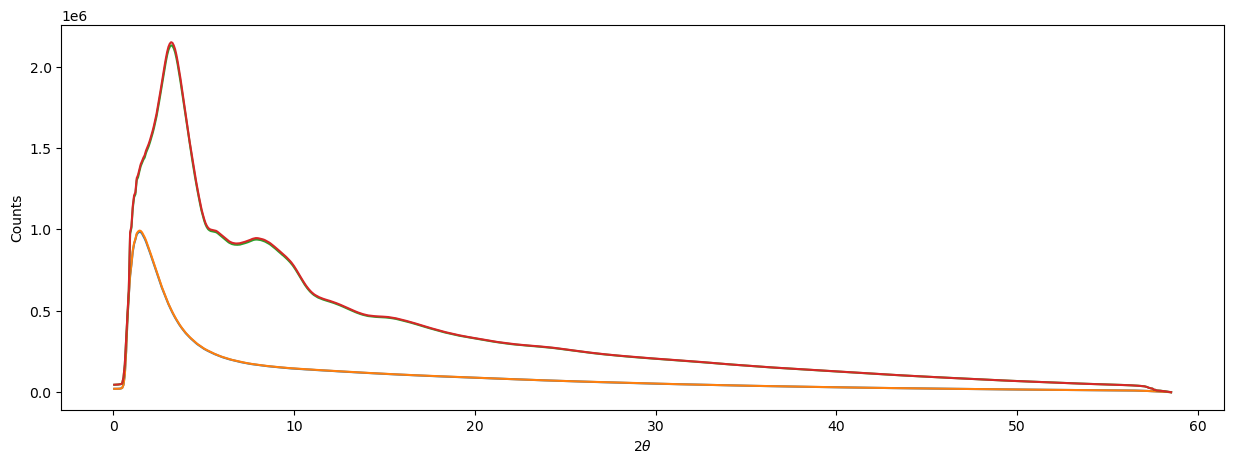

In [19]:
plt.figure(figsize = (15, 5))
plt.plot(tx1, y1, label = 'Air, 1')
plt.plot(tx2, y2, label = 'Air, 2')
plt.plot(tx2, y3, label = 'Glass, 1')
plt.plot(tx3, y4, label = 'Glass, 2')
plt.xlabel('2$\\theta$')
plt.ylabel('Counts')

In [63]:
# Estimate gain measurement from two glass measurements
gmap1 = estimate_gain(g1, tmap, 40, 50, 1600)
gmap2 = estimate_gain(g2, tmap, 40, 50, 1600)

# Average two averaged gain maps
gmap = np.nanmean((gmap1, gmap2), axis = 0)

# Apply corrections to map (median filter, remove any NaNs)
# 7x7 median filter used for perkin elmer detectors
cmap = map_correction(gmap, 7)

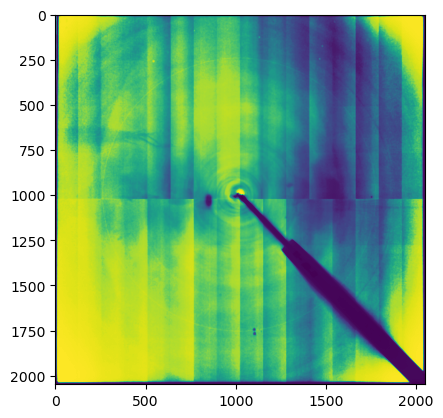

In [65]:
plt.imshow(equalize_hist(cmap))

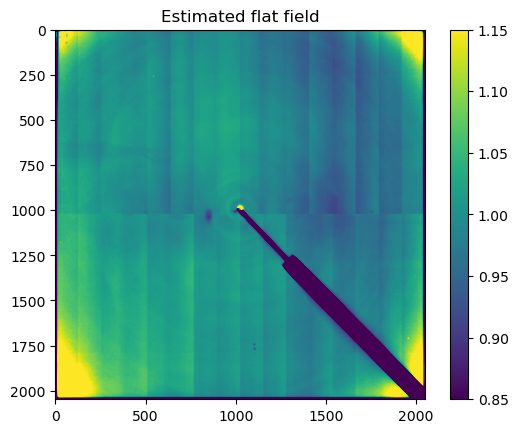

In [78]:
plt.imshow(cmap, vmin = 0.85, vmax = 1.15)
plt.title('Estimated flat field')
plt.colorbar()

In [45]:
data = imread('Cs_0p4_3mm_ps1_c12-000000.tif')

In [81]:
# Apply gain map
test = np.nan_to_num(data/gmap1) # Remove any nans
# Remove any very large or very small values created by inf or -inf
test[test>10**300] = 0
test[test<-10**300] = 0

C:\Users\jmswe\AppData\Local\Temp\ipykernel_22660\3898416238.py:2: RuntimeWarning: divide by zero encountered in divide
  test = np.nan_to_num(data/gmap1) # Remove any nans
C:\Users\jmswe\AppData\Local\Temp\ipykernel_22660\3898416238.py:2: RuntimeWarning: invalid value encountered in divide
  test = np.nan_to_num(data/gmap1) # Remove any nans


Text(0.5, 1.0, 'Gain corrected image, histogram equalized')

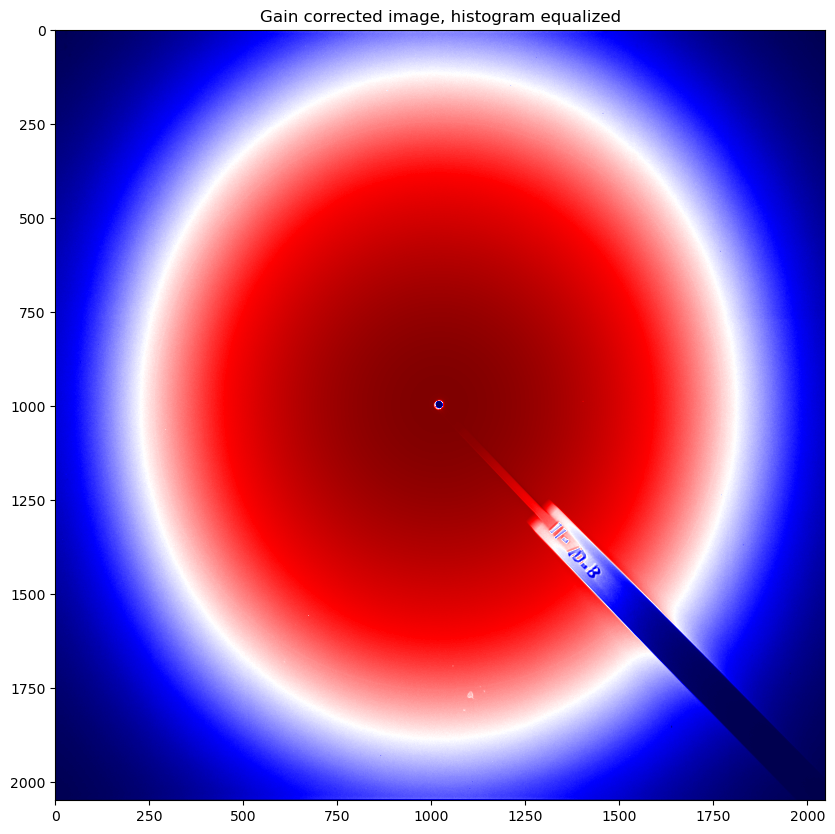

In [82]:
plt.figure(figsize = (10, 10))
plt.imshow(equalize_hist(test), cmap = 'seismic')
plt.title('Gain corrected image, histogram equalized')

Text(0.5, 1.0, 'Input data, histogram equalized')

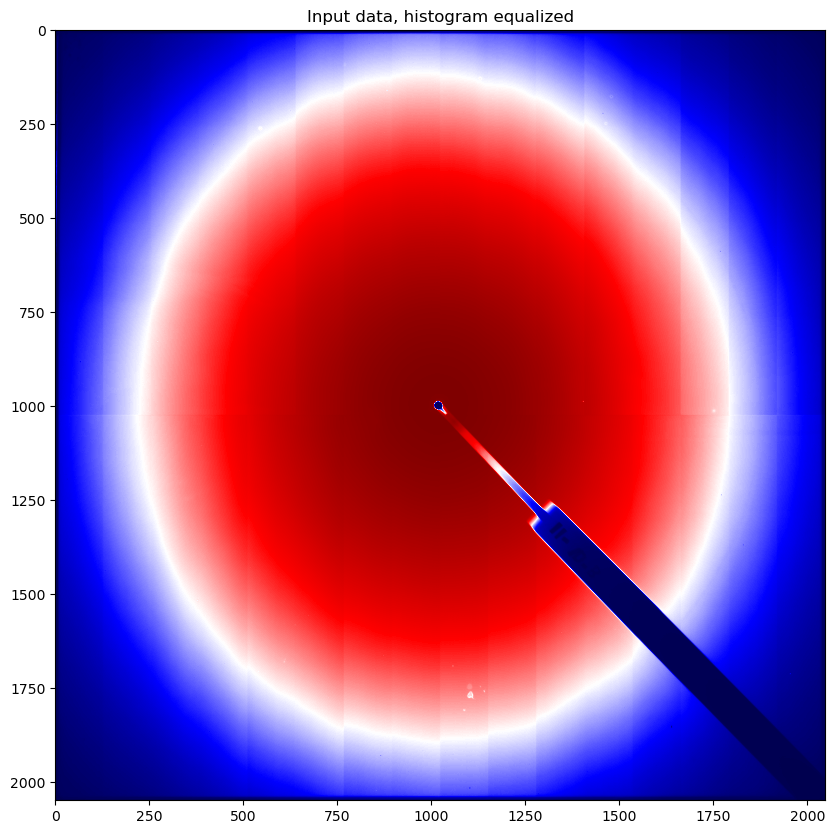

In [74]:
plt.figure(figsize = (10, 10))
plt.imshow(equalize_hist(data), cmap = 'seismic')
plt.title('Input data, histogram equalized')

In [88]:
# Export calculated gain map
gainmapfilename = 'Estimated gain map'
# Define gain map format
g_form = 0 # Set to 1 if the gain map is to be divided by measured images, 0 if it is to be multiplied (GSAS wants multiply)

# Change to whatever format and then remove any nans which may be present
if g_form == 1:
    nmap = np.nan_to_num(cmap)
if g_form == 0:
    nmap = np.nan_to_num(1/cmap)
else:
    nmap = np.nan_to_num(cmap) # Format parameter to something other than 0 returns a multiplied map
# Remove any inf/very large values created by any divide by zeros
nmap[nmap>10**10] = 0
nmap[nmap<-10**10] = 0

# Export map as 32 bit tif
im = Image.fromarray(np.float32(nmap), mode='F') # float32
im.save(gainmapfilename+'_'+datetime.today().strftime('%Y-%m-%d')+'.tif', 'TIFF')